# Qaintellect implementation of the Warm-Start Quantum Optimization Algorithm (WS-QAOA, R-WS-QAOA)

In this example, we implement the optimization of a circuit based on the QAOA algorithm using a warm-start, demonstrated via the Max-Cut problem. Ideally the warm start is close to the optimal solution, which would lead to faster and better convergence than using normal QAOA.

Reference:
- Egger, Daniel J., Jakub Mareček, and Stefan Woerner “Warm-starting quantum optimization” Quantum 5 (June 2021): 479. [doi:10.22331](https://doi.org/10.22331/q-2021-06-17-479E) (2021)

In [1]:
using Qaintessent
using Qaintessent.MaxCutWSQAOA
using Qaintessent.MaxKColSubgraphQAOA
using Qaintessent.QAOAHelperDataStructs
using Qaintellect
using LinearAlgebra
using Flux
using IterTools: ncycle
using MaxCut

In [2]:
# visualization
using Plots
using LaTeXStrings

In [3]:
# Prepares a ready to use WS-QAOA circuit
# The gates are implemented in Qaintessent.jl module
function ws_qaoa_maxcut_circuit(γs::Vector{Float64}, βs::Vector{Float64}, ws_partitioning::Vector{Float64}, 
        graph::EdgeWeightedGraph, ε::Float64, init_state_randomized::Bool)
    gates::Vector{CircuitGate} = []
    # ws-qaoa circuit
    for (γ, β) in zip(γs, βs)
        # Add the phase separation gate
        phase_separation_gate =  MaxCutPhaseSeparationGate(γ, graph)
        push!(gates, CircuitGate(Tuple(1:graph.n), phase_separation_gate))
        # Add WS-MaxCut Mixer
        mixer_gate = WSQAOAMixerGate(β, ws_partitioning, ε, init_state_randomized)
        # mixer_gate = RxMixerGate(β, graph.n)
        push!(gates, CircuitGate(Tuple(1:graph.n), mixer_gate))
    end
    # One-hot encoding: each qubit represents one node exactly
    Circuit{graph.n}(gates)
end

ws_qaoa_maxcut_circuit (generic function with 1 method)

In [4]:
# Prepares the init state from a given solution, can be continous or discrete (p. 3)
function prepare_init_state(ws_partitioning::Vector{Float64}, ε::Float64)
    gates::Vector{CircuitGate} = []
    n = length(ws_partitioning)
    # prepare the initial state
    for i in eachindex(ws_partitioning)
        # calculate theta according to regularization parameter and partitioning: Sec. (2.2)
        c_i = ws_partitioning[i]
        c_i = c_i <= ε ? ε : c_i
        c_i = c_i >= (1 - ε) ? (1 - ε) : c_i
        theta_i = 2 * asin(sqrt(c_i))
        push!(gates, CircuitGate(Tuple(i,), RyGate(theta_i)))
    end
    init_circ = Circuit{n}(gates)
    # starting point: |0>
    start_point = zeros(ComplexF64, 2^n)
    start_point[1] = 1.0 + 0.0im
    return apply(start_point, init_circ.moments)
end

prepare_init_state (generic function with 1 method)

In [5]:
# Trains a WS-QAOA circuit and prints the objective function in every round
function optimize_ws_qaoa(graph::EdgeWeightedGraph, ws_partitioning::Vector{Float64}, ε::Float64, init_state_randomized::Bool, 
        p::Int, training_rounds::Int=10, learning_rate::Float64=0.005, 
        params::Tuple{Vector{Float64}, Vector{Float64}}=([0.0],[0.0]), init_stddev=1, logger::Any=nothing)
    ((isnothing(p) || p > 0) && training_rounds > 0) ||
        throw(DomainError("`p` and `training_rounds` must be positive integers."))
    # Initialize circuit and wavefunction
    (initial_γs, initial_βs) = params
    if (initial_γs, initial_βs) == ([0.0], [0.0])
        (initial_γs, initial_βs) = (2 * π * randn(p) * init_stddev, 2 * π * randn(p) * init_stddev)
    end
    circ = ws_qaoa_maxcut_circuit(initial_γs, initial_βs, ws_partitioning, graph, ε, init_state_randomized)
    ws = prepare_init_state(ws_partitioning, ε)
    H_P_diag = diag(max_cut_phase_separation_hamiltonian(graph)) # can't have `Diagonal` matrix type here (error in backprop)
    # Set up optimization with Flux
    params = Flux.params(circ)
    data = repeat([()], training_rounds) # empty input data for `training_rounds` rounds of training
    optimizer = ADAM(learning_rate)
    objective = real(ws' * (H_P_diag .* ws))
    println("Training, round 0: average objective = $(objective)")
    round = 1
    # evaluate expectation <f> to be minimized and print it
    prev_objective = 0.0
    counter = 0
    max_counter = 30
    expectation() = begin
        par = Flux.params(circ)
        ws_out = apply(ws, circ.moments)
        objective = real(ws_out' * (H_P_diag .* ws_out))
        if abs(objective - prev_objective) > 0.001
            counter = 0
        elseif counter >= max_counter
            println("No significant improvement, early stopping...")
            Flux.stop()
        else
            counter += 1
        end
        prev_objective = objective
        println("Training, round $(round): average objective=$(objective)")
        if !isnothing(logger)
            log_qaoa(logger, round, ws_out, objective, params)
        end
        round += 1
        return -objective
    end
    
    # Perform training
    Flux.train!(expectation, params, data, optimizer)
    return circ
end

optimize_ws_qaoa (generic function with 6 methods)

In [6]:
# Implements the recursive version of the QAOA for MaxCut
# Returns a tuple like this: (cut_size, (partition1, partition2))
# Right now cut_size is not correctly shown (gives 0),
# however the implementation is correct
function recursive_ws_qaoa(graph::EdgeWeightedGraph, ws_partitioning::Vector{Float64}, ε::Float64, init_state_randomized::Bool, 
        p::Int, training_rounds::Int=10, learning_rate::Float64=0.01, 
        init_stddev=1, logger::Any=nothing) where {N}
    if graph.n <= 2 || length(graph.edges) <= 1
        # Initialize circuit and wavefunction
        println("End of recursion!")
        println("graph n: $(graph.n), graph edges: $(graph.edges)")
        res = (0.0, ([1], [2]))
        if length(graph.edges) == 1 && graph.n > 2
            v = first(first(first(graph.edges))) # select the first node
            res = (0.0, ([v], setdiff(Vector(1:graph.n), [v])))
        elseif graph.n > 2
            res = (0.0, ([], Vector(1:graph.n)))
        end
        println("res: $(res)")
        return res
    end
    ws = prepare_init_state(ws_partitioning, ε)
    (initial_γs, initial_βs) = ([0.0], [0.0])
    opt_circ = optimize_ws_qaoa(graph, ws_partitioning, ε, init_state_randomized, p, training_rounds, learning_rate, (initial_γs, initial_βs), init_stddev, logger)
    ws_out = apply(ws, opt_circ.moments)
    (max_corr, corr_edge) = (0, (-1, -1))
    for (edge, w) in graph.edges
        correlator =  kron((i ∈ edge ? matrix(Z) : I(2) for i in 1:graph.n)...)
        corr = ws_out' * correlator * ws_out
        if abs(corr) >= abs(max_corr)
            max_corr = corr
            corr_edge = edge
        end
    end
    (v_out, v_k) = corr_edge
    adj_mat = adjacency_matrix(graph)
    reduced_edges::Vector{Tuple{Int, Int, Float64}} = []
    # replace v_out with sign(max_corr)*v_k
    for (edge, w) in graph.edges
        if !(v_out ∈ edge) 
            (v_i, v_j) = edge
            v_i_updated = v_i > v_out ? v_i - 1 : v_i
            v_j_updated = v_j > v_out ? v_j - 1 : v_j
            extra_weight = 0.0
            if v_i == v_k
                extra_weight = sign(max_corr) * adj_mat[v_j, v_out]
            elseif v_j == v_k
                extra_weight = sign(max_corr) * adj_mat[v_i, v_out]
            else
                extra_weight = 0.0
            end
            push!(reduced_edges, (v_i_updated, v_j_updated, w + real(extra_weight)))
        end
    end
    reduced_graph = EdgeWeightedGraph(graph.n - 1, reduced_edges)
    reduced_partitioning = ws_partitioning[1:graph.n .!= v_out]
    (cut_size, partitions) = recursive_ws_qaoa(reduced_graph, reduced_partitioning, ε, 
        init_state_randomized, p, training_rounds, learning_rate, init_stddev, logger)
    (partition1, partition2) = partitions
    println("return from recursion")
    println("partitions: $(partitions)")
    println("v_out: $(v_out)")
    for i in 1:length(partition1)
        partition1[i] = partition1[i] >= v_out ? partition1[i] + 1 : partition1[i]
    end
    for i in 1:length(partition2)
        partition2[i] = partition2[i] >= v_out ? partition2[i] + 1 : partition2[i]
    end
    if v_k ∈ partition1
        if real(sign(max_corr)) <= 0
            push!(partition2, v_out)
        else
            push!(partition1, v_out)
        end
    else
        if real(sign(max_corr)) <= 0
            push!(partition1, v_out)
        else
            push!(partition2, v_out)
        end
    end
    return (cut_size, (partition1, partition2))
end

recursive_ws_qaoa (generic function with 5 methods)

# Normal QAOA vs. WS-QAOA

To simulate a normal QAOA, we can set the regularization parameter to 0.5 and WS-QAOA will be mapped to normal QAOA (Eq. 2). However, for the reference, normal X-Mixer gate is also implemented. Feel free to check the QAOA library in the Qaintessent.jl modules for all the gates that are implemented.

With 8 qubits, we can construct a three-connected graph, which is basically a cube:

<img src="./img/wsqaoa-cube.png"
     alt="N=8"
     style="float: left; width: 500px" />
     

In [269]:
n = 8
edges = [(1, 2), (1, 4), (1, 5), (2, 3), (2, 6), (3, 4), (3, 7), (4, 8), (5, 6), (5, 8), (6, 7), (7, 8)];
graph = Graph(n, edges)
ws_partitioning = [1.0, 0.0, 1.0, 0.0, 0.0 ,1.0, 0.0, 0.0]
ε = 0.5
init_state_randomized = false
p = 10
rounds = 300
lr = 0.01
init_stddev = 1
(max_cut, max_partition) = maxcut(adjacency_matrix(to_edge_weighted_graph(graph)), iter=1)

(12, ([2, 4, 5, 7], [1, 3, 6, 8]))

Now let's try to find the optimal cut in normal QAOA:

In [155]:
p = 10
ε = 0.5
(initial_γs_10, initial_βs_10) = (2 * π * randn(p) * init_stddev, 2 * π * randn(p) * init_stddev)
circ_opt_10 = optimize_ws_qaoa(to_edge_weighted_graph(graph), ws_partitioning, ε, init_state_randomized, p, rounds, lr, (initial_γs_10, initial_βs_10))


Training, round 0: average objective = 6.0
Training, round 1: average objective=6.3040810353947645
Training, round 2: average objective=6.7218782115258096
Training, round 3: average objective=7.051937034184426
Training, round 4: average objective=7.324159592624407
Training, round 5: average objective=7.559777302142224
Training, round 6: average objective=7.752957559347965
Training, round 7: average objective=7.903748489952986
Training, round 8: average objective=8.028782991816797
Training, round 9: average objective=8.148863215141624
Training, round 10: average objective=8.279246090696276
Training, round 11: average objective=8.428569521308734
Training, round 12: average objective=8.598400543699414
Training, round 13: average objective=8.784421934431352
Training, round 14: average objective=8.978960174635322
Training, round 15: average objective=9.170374342374828
Training, round 16: average objective=9.342565067671973
Training, round 17: average objective=9.480568113397403
Training, ro


    8 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    7 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    6 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     

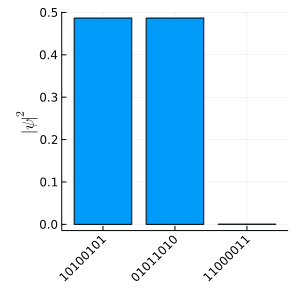

In [274]:
result = apply(prepare_init_state(ws_partitioning, ε), circ_opt_10.moments)
result_arg_sorted = sortperm(abs2.(result))
first_arg = result_arg_sorted[length(result_arg_sorted)]
second_arg = result_arg_sorted[length(result_arg_sorted) - 1]
third_arg = result_arg_sorted[length(result_arg_sorted) - 2]
probs = [abs2(result[first_arg]), abs2(result[second_arg]), abs2(result[third_arg])]
tags = [join(reverse(digits(first_arg-1, pad = n, base = 2))), join(reverse(digits(second_arg-1, pad = n, base = 2))), join(reverse(digits(third_arg-1, pad = n, base = 2)))]
bar(tags, probs, xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false, size=(300, 300))

In [30]:
p = 8
ε = 0.5
(initial_γs_8, initial_βs_8) = (2 * π * randn(p) * init_stddev, 2 * π * randn(p) * init_stddev)
circ_opt_8 = optimize_ws_qaoa(to_edge_weighted_graph(graph), ws_partitioning, ε, init_state_randomized, p, rounds, lr, (initial_γs, initial_βs))

Training, round 0: average objective = 6.0
Training, round 1: average objective=6.058878548624268
Training, round 2: average objective=6.277669975216873
Training, round 3: average objective=6.5274691617254135
Training, round 4: average objective=6.802351987351771
Training, round 5: average objective=7.076202471313104
Training, round 6: average objective=7.314318920524856
Training, round 7: average objective=7.487369741888635
Training, round 8: average objective=7.602822365979888
Training, round 9: average objective=7.7023146586173645
Training, round 10: average objective=7.820255348199024
Training, round 11: average objective=7.971977430137235
Training, round 12: average objective=8.158775214924965
Training, round 13: average objective=8.374186681860257
Training, round 14: average objective=8.607868548058692
Training, round 15: average objective=8.847771539796154
Training, round 16: average objective=9.082111025477227
Training, round 17: average objective=9.301707357418046
Training, ro

Training, round 145: average objective=11.737947898844064
Training, round 146: average objective=11.738352436622472
Training, round 147: average objective=11.738737292057838
Training, round 148: average objective=11.739104137348992
Training, round 149: average objective=11.73945418245846
Training, round 150: average objective=11.73978801471117
Training, round 151: average objective=11.740106038416197
Training, round 152: average objective=11.740408901021365
Training, round 153: average objective=11.74069747959543
Training, round 154: average objective=11.74097258664892
Training, round 155: average objective=11.741234826573992
Training, round 156: average objective=11.74148472242338
No significant improvement, early stopping...



    8 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    7 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    6 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    4 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |   

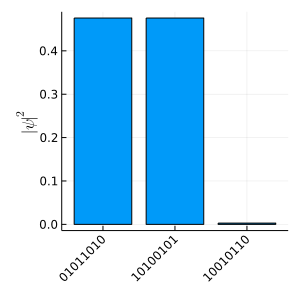

In [277]:
result = apply(prepare_init_state(ws_partitioning, ε), circ_opt_8.moments)
result_arg_sorted = sortperm(abs2.(result))
first_arg = result_arg_sorted[length(result_arg_sorted)]
second_arg = result_arg_sorted[length(result_arg_sorted) - 1]
third_arg = result_arg_sorted[length(result_arg_sorted) - 2]
probs = [abs2(result[first_arg]), abs2(result[second_arg]), abs2(result[third_arg])]
tags = [join(reverse(digits(first_arg-1, pad = n, base = 2))), join(reverse(digits(second_arg-1, pad = n, base = 2))), join(reverse(digits(third_arg-1, pad = n, base = 2)))]
bar(tags, probs, xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false, size=(300, 300))

In [162]:
p = 4
ε = 0.5
(initial_γs_4, initial_βs_4) = (2 * π * randn(p) * init_stddev, 2 * π * randn(p) * init_stddev)
circ_opt_4 = optimize_ws_qaoa(to_edge_weighted_graph(graph), ws_partitioning, ε, init_state_randomized, p, rounds, lr, (initial_γs_4, initial_βs_4))

Training, round 0: average objective = 6.0
Training, round 1: average objective=5.689738911996825
Training, round 2: average objective=5.785204888270998
Training, round 3: average objective=5.887062523510816
Training, round 4: average objective=5.994241608410095
Training, round 5: average objective=6.104905531398832
Training, round 6: average objective=6.216980119176496
Training, round 7: average objective=6.328331457491661
Training, round 8: average objective=6.437051171332259
Training, round 9: average objective=6.542032657220658
Training, round 10: average objective=6.643968759625607
Training, round 11: average objective=6.745978116518845
Training, round 12: average objective=6.852157815188232
Training, round 13: average objective=6.965402553044303
Training, round 14: average objective=7.086841115530212
Training, round 15: average objective=7.21630200588677
Training, round 16: average objective=7.3528546706571625
Training, round 17: average objective=7.4951647419031575
Training, rou

Training, round 147: average objective=9.568748944890196
Training, round 148: average objective=9.591121297062939
Training, round 149: average objective=9.613825982566766
Training, round 150: average objective=9.636724153738005
Training, round 151: average objective=9.659675809300335
Training, round 152: average objective=9.682543392145156
Training, round 153: average objective=9.70519541765967
Training, round 154: average objective=9.727509296224202
Training, round 155: average objective=9.749374066373184
Training, round 156: average objective=9.770691944872937
Training, round 157: average objective=9.791378994531911
Training, round 158: average objective=9.811365002702383
Training, round 159: average objective=9.830592633645097
Training, round 160: average objective=9.849016617460856
Training, round 161: average objective=9.866602617675744
Training, round 162: average objective=9.883326404770816
Training, round 163: average objective=9.899172506438974
Training, round 164: average obj


    8 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    7 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    6 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    4 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    3 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    2 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    1 ——□—————□—————□—————□—————□—————□—————□—————□———


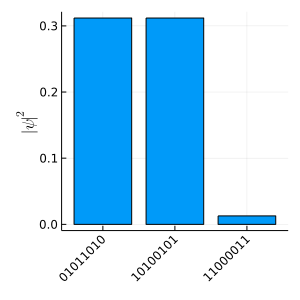

In [273]:
result = apply(prepare_init_state(ws_partitioning, ε), circ_opt_4.moments)
result_arg_sorted = sortperm(abs2.(result))
first_arg = result_arg_sorted[length(result_arg_sorted)]
second_arg = result_arg_sorted[length(result_arg_sorted) - 1]
third_arg = result_arg_sorted[length(result_arg_sorted) - 2]
probs = [abs2(result[first_arg]), abs2(result[second_arg]), abs2(result[third_arg])]
tags = [join(reverse(digits(first_arg-1, pad = n, base = 2))), join(reverse(digits(second_arg-1, pad = n, base = 2))), join(reverse(digits(third_arg-1, pad = n, base = 2)))]
bar(tags, probs, xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false, size=(300, 300))

Now let's try to find the optimal cut again in Warm-starting QAOA with less depth:

In [157]:
ws_partitioning = [1.0, 0.0, 1.0, 0.0, 0.0 ,1.0, 0.0, 0.5]
ε = 0.4
init_state_randomized = false
p = 8
rounds = 300
lr = 0.01
(max_cut, max_partition)

(12, ([1, 3, 6, 8], [2, 4, 5, 7]))

In [158]:
circ_opt_ws_8 = optimize_ws_qaoa(to_edge_weighted_graph(graph), ws_partitioning, ε, init_state_randomized, p, rounds, lr, (initial_γs, initial_βs))

Training, round 0: average objective = 6.180000000000004
Training, round 1: average objective=7.060063964674294
Training, round 2: average objective=7.332976458900674
Training, round 3: average objective=7.617049829655759
Training, round 4: average objective=7.8961680557560285
Training, round 5: average objective=8.156317294435837
Training, round 6: average objective=8.38623692841408
Training, round 7: average objective=8.574452727220411
Training, round 8: average objective=8.715457684946966
Training, round 9: average objective=8.819112164584828
Training, round 10: average objective=8.906788682948765
Training, round 11: average objective=8.997128831842188
Training, round 12: average objective=9.099223224946025
Training, round 13: average objective=9.2126772559503
Training, round 14: average objective=9.330353947078706
Training, round 15: average objective=9.442670583354543
Training, round 16: average objective=9.541848382772802
Training, round 17: average objective=9.622961296840057
Tr

Training, round 145: average objective=11.420630453731512
Training, round 146: average objective=11.42548542240321
Training, round 147: average objective=11.429795170643038
Training, round 148: average objective=11.433544825773225
Training, round 149: average objective=11.436731062315538
Training, round 150: average objective=11.439363208117141
Training, round 151: average objective=11.441464010016503
Training, round 152: average objective=11.443069613612057
Training, round 153: average objective=11.444228752528227
Training, round 154: average objective=11.44500083536679
Training, round 155: average objective=11.445453370070682
Training, round 156: average objective=11.4456585468231
Training, round 157: average objective=11.445689163585456
Training, round 158: average objective=11.445614753185957
Training, round 159: average objective=11.445497890531698
Training, round 160: average objective=11.445391066240681
Training, round 161: average objective=11.445334760589462
Training, round 16


    8 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    7 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    6 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    4 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |   

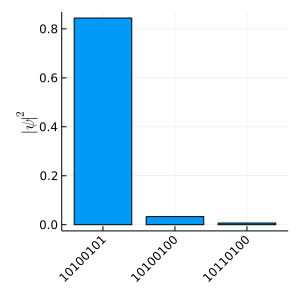

In [278]:
result = apply(prepare_init_state(ws_partitioning, ε), circ_opt_ws_8.moments)
result_arg_sorted = sortperm(abs2.(result))
first_arg = result_arg_sorted[length(result_arg_sorted)]
second_arg = result_arg_sorted[length(result_arg_sorted) - 1]
third_arg = result_arg_sorted[length(result_arg_sorted) - 2]
probs = [abs2(result[first_arg]), abs2(result[second_arg]), abs2(result[third_arg])]
tags = [join(reverse(digits(first_arg-1, pad = n, base = 2))), join(reverse(digits(second_arg-1, pad = n, base = 2))), join(reverse(digits(third_arg-1, pad = n, base = 2)))]
bar(tags, probs, xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false, size=(300, 300))

Interestingly, the warm-start does not scale well with increasing depth. Usually, if the depth is good enough for the normal QAOA, WS-QAOA will at most perform as good as normal QAOA. The reason for that lies in the gradient calculation. When the warm-starting is used, the mixer matrix gets really complicated, and the current gradient calculation (the current method is a single forward difference) is not stable enough to represent that complexity.

However, if we lower the depth furthermore:

In [174]:
p = 4
ε = 0.25
circ_opt_ws_4 = optimize_ws_qaoa(to_edge_weighted_graph(graph), ws_partitioning, ε, init_state_randomized, p, rounds, lr)

Training, round 0: average objective = 7.124999999999999
Training, round 1: average objective=7.29172347308156
Training, round 2: average objective=7.522724396644229
Training, round 3: average objective=7.768205978535373
Training, round 4: average objective=8.021698959038703
Training, round 5: average objective=8.276131103183467
Training, round 6: average objective=8.524980066451787
Training, round 7: average objective=8.764506527524986
Training, round 8: average objective=8.992883949371018
Training, round 9: average objective=9.207235225036094
Training, round 10: average objective=9.404175283749929
Training, round 11: average objective=9.580964526352231
Training, round 12: average objective=9.736123539832
Training, round 13: average objective=9.869708103621198
Training, round 14: average objective=9.98326106789823
Training, round 15: average objective=10.079482496875077
Training, round 16: average objective=10.16178383594987
Training, round 17: average objective=10.233881546474235
Tra

Training, round 144: average objective=11.711780565571605
Training, round 145: average objective=11.712141032402053
Training, round 146: average objective=11.712489533995788
Training, round 147: average objective=11.71282642541723
Training, round 148: average objective=11.713152078388777
Training, round 149: average objective=11.713466884235906
Training, round 150: average objective=11.713771239477676
Training, round 151: average objective=11.714065503012487
Training, round 152: average objective=11.714350002887056
Training, round 153: average objective=11.714625116318022
Training, round 154: average objective=11.714891161893988
Training, round 155: average objective=11.715148442965084
Training, round 156: average objective=11.715397179134648
Training, round 157: average objective=11.715637665787066
Training, round 158: average objective=11.715870126696956
Training, round 159: average objective=11.716094818538938
Training, round 160: average objective=11.716312006971826
Training, round

Training, round 286: average objective=11.722792491619703
Training, round 287: average objective=11.722797955574995
Training, round 288: average objective=11.722803288212374
Training, round 289: average objective=11.722808496335203
Training, round 290: average objective=11.72281357851115
Training, round 291: average objective=11.722818536314694
Training, round 292: average objective=11.722823376496317
Training, round 293: average objective=11.72282809890965
Training, round 294: average objective=11.722832704539151
Training, round 295: average objective=11.722837197999239
Training, round 296: average objective=11.722841582906884
Training, round 297: average objective=11.722845860875923
Training, round 298: average objective=11.7228500383507
Training, round 299: average objective=11.722854115542564
Training, round 300: average objective=11.722858093458479



    8 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    7 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    6 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    4 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    3 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    2 ——□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |   
    1 ——□—————□—————□—————□—————□—————□—————□—————□———


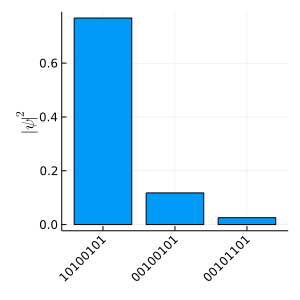

In [272]:
result = apply(prepare_init_state(ws_partitioning, ε), circ_opt_ws_4.moments)
result_arg_sorted = sortperm(abs2.(result))
first_arg = result_arg_sorted[length(result_arg_sorted)]
second_arg = result_arg_sorted[length(result_arg_sorted) - 1]
third_arg = result_arg_sorted[length(result_arg_sorted) - 2]
probs = [abs2(result[first_arg]), abs2(result[second_arg]), abs2(result[third_arg])]
tags = [join(reverse(digits(first_arg-1, pad = n, base = 2))), join(reverse(digits(second_arg-1, pad = n, base = 2))), join(reverse(digits(third_arg-1, pad = n, base = 2)))]
bar(tags, probs, xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false, size=(300, 300))

Now we see the real benefit of warm-starting, it can find the solution with high probability even at depth 4, where normal QAOA cannot.

It is even possible to further lower the depth, if we switch to recursive WS-QAOA.

In [198]:
p = 2
ε = 0.25
ws_rqaoa_result = recursive_ws_qaoa(to_edge_weighted_graph(graph), ws_partitioning, ε, init_state_randomized, p, rounds, lr)

Training, round 0: average objective = 7.124999999999999
Training, round 1: average objective=4.861819601751252
Training, round 2: average objective=4.907596565355103
Training, round 3: average objective=4.961693024227362
Training, round 4: average objective=5.023621097262167
Training, round 5: average objective=5.093240969367077
Training, round 6: average objective=5.170218258829361
Training, round 7: average objective=5.2541427127454154
Training, round 8: average objective=5.344520496486968
Training, round 9: average objective=5.440763842931434
Training, round 10: average objective=5.542184285216424
Training, round 11: average objective=5.647989426102651
Training, round 12: average objective=5.757284178368556
Training, round 13: average objective=5.869077050105135
Training, round 14: average objective=5.982292530016345
Training, round 15: average objective=6.095790741526512
Training, round 16: average objective=6.208395225807733
Training, round 17: average objective=6.318930070408443

Training, round 13: average objective=4.626632323266081
Training, round 14: average objective=4.653626521007684
Training, round 15: average objective=4.680407587372693
Training, round 16: average objective=4.706584470937274
Training, round 17: average objective=4.731742667271283
Training, round 18: average objective=4.7554659150365985
Training, round 19: average objective=4.777359384666293
Training, round 20: average objective=4.797073855438749
Training, round 21: average objective=4.8143303162051225
Training, round 22: average objective=4.828942128594446
Training, round 23: average objective=4.840832907417138
Training, round 24: average objective=4.850046392806927
Training, round 25: average objective=4.856744479541026
Training, round 26: average objective=4.861192801074257
Training, round 27: average objective=4.86373512281348
Training, round 28: average objective=4.8647618327473
Training, round 29: average objective=4.864678124786368
Training, round 30: average objective=4.863876786

Training, round 24: average objective=3.8854075223786593
Training, round 25: average objective=3.905459118857995
Training, round 26: average objective=3.923724119323886
Training, round 27: average objective=3.940394151212667
Training, round 28: average objective=3.955753566633639
Training, round 29: average objective=3.970156202256786
Training, round 30: average objective=3.9839917089953834
Training, round 31: average objective=3.9976468301371932
Training, round 32: average objective=4.011468889965839
Training, round 33: average objective=4.025736839359347
Training, round 34: average objective=4.040643416894965
Training, round 35: average objective=4.056288283672554
Training, round 36: average objective=4.072681055290239
Training, round 37: average objective=4.08975079870649
Training, round 38: average objective=4.107360688243785
Training, round 39: average objective=4.125325610328304
Training, round 40: average objective=4.143431158786969
Training, round 41: average objective=4.161453

Training, round 3: average objective=1.0164895018422393
Training, round 4: average objective=1.0264594064701003
Training, round 5: average objective=1.0368490848674659
Training, round 6: average objective=1.0476904968009468
Training, round 7: average objective=1.059079110077838
Training, round 8: average objective=1.071234709735943
Training, round 9: average objective=1.0845867599643373
Training, round 10: average objective=1.0998021354601974
Training, round 11: average objective=1.1176262929751597
Training, round 12: average objective=1.1386410134623839
Training, round 13: average objective=1.1631850961834782
Training, round 14: average objective=1.1914120819047582
Training, round 15: average objective=1.2233536203130155
Training, round 16: average objective=1.258952272462486
Training, round 17: average objective=1.2980744683261862
Training, round 18: average objective=1.3405151548814123
Training, round 19: average objective=1.3860000196025384
Training, round 20: average objective=1.4

Training, round 58: average objective=1.8563303727409501
Training, round 59: average objective=1.860881321969672
Training, round 60: average objective=1.8652903491515722
Training, round 61: average objective=1.8695488616217741
Training, round 62: average objective=1.873650166273915
Training, round 63: average objective=1.8775894755864764
Training, round 64: average objective=1.8813638676329718
Training, round 65: average objective=1.8849721295078297
Training, round 66: average objective=1.8884145733865028
Training, round 67: average objective=1.891692816877994
Training, round 68: average objective=1.8948095353980143
Training, round 69: average objective=1.8977682290613422
Training, round 70: average objective=1.9005730006286308
Training, round 71: average objective=1.903228356770542
Training, round 72: average objective=1.9057390370104177
Training, round 73: average objective=1.908109882086199
Training, round 74: average objective=1.9103457362425753
Training, round 75: average objectiv

(0.0, (Any[5, 7, 2, 4], [1, 3, 8, 6]))

# Overall Convergence vs. Qubits x Parameter x Rounds Comparison

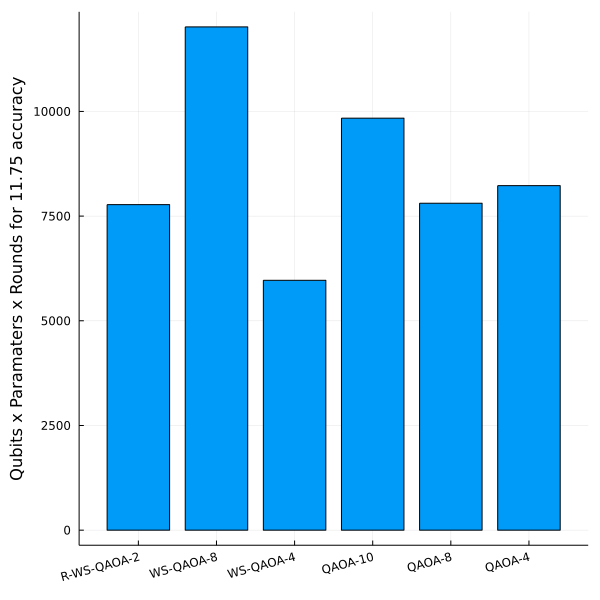

In [280]:
r_ws_qaoa_time = (131 * 8 + 133 * 7 + 168 * 6 + 88 * 5 + 115 * 4) * 2.0
ws_qaoa_8_time = 183 * 8 * 8.0 * (11.75 / 11.45)
ws_qaoa_4_time = 186 * 8 * 4.0 * (11.75 / 11.72)
qaoa_10_time = 123 * 10 * 8.0
qaoa_8_time = 122 * 8 * 8.0
qaoa_4_time = 221 * 8 * 4.0 * (11.75 / 10.1)

qaoa_times = [r_ws_qaoa_time, ws_qaoa_8_time, ws_qaoa_4_time, qaoa_10_time, qaoa_8_time, qaoa_4_time]
tags = ["R-WS-QAOA-2", "WS-QAOA-8", "WS-QAOA-4", "QAOA-10", "QAOA-8", "QAOA-4"]
bar(tags, qaoa_times, xticks=:all, xrotation=15, ylabel="Qubits x Paramaters x Rounds for 11.75 accuracy", legend=false, size=(600, 600))

# WS-QAOA vs. R-WS-QAOA

It turns out, this example cannot be optimally solved with WS-QAOA even at depth 20!

<img src="./img/wsqaoa-neg-pos.png"
     alt="N=8"
     style="float: left; width: 500px" />
     

In [253]:
# Example graph with negative/positive edge weights, shown at: Fig (9)
edges = [
    (1, 2, 3.0), (1, 3, 3.0), (1, 4, 6.0), (1, 5, 9.0), (1, 6, 1.0),
    (2, 3, 4.0), (2, 4, 4.0), (2, 5, -8.0), (2, 6, 4.0),
    (3, 4, 3.0), (3, 5, -7.0), (3, 6, 1.0),
    (4, 5, -7.0), (4, 6, 6.0),
    (5, 6, -5.0)
]
n = 6
graph = EdgeWeightedGraph(n, edges)
ws_partitioning = [0.0, 0.0, 1.0, 1.0, 1.0, 1.0]
ε = 0.25
init_state_randomized = true
lr = 0.01
p = 20
rounds = 300

300

In [254]:
p = 20
circ_opt_fail = optimize_ws_qaoa(graph, ws_partitioning, ε, init_state_randomized, p, rounds, lr)

Training, round 0: average objective = 6.125000000000001
Training, round 1: average objective=8.382162533825813
Training, round 2: average objective=10.720511985912697
Training, round 3: average objective=11.878754680487033
Training, round 4: average objective=12.926689913745992
Training, round 5: average objective=13.55960612349832
Training, round 6: average objective=14.148391916808734
Training, round 7: average objective=14.91798995852805
Training, round 8: average objective=15.831404329188652
Training, round 9: average objective=16.560540703077294
Training, round 10: average objective=16.81896548856927
Training, round 11: average objective=16.8915128514225
Training, round 12: average objective=17.05889973113463
Training, round 13: average objective=17.25505927329069
Training, round 14: average objective=17.431605426003983
Training, round 15: average objective=17.600515931843873
Training, round 16: average objective=17.7000836582436
Training, round 17: average objective=17.794530573

Training, round 145: average objective=22.356066666990323
Training, round 146: average objective=22.356175838855393
Training, round 147: average objective=22.35622648260621
Training, round 148: average objective=22.35623827951703
Training, round 149: average objective=22.356235601365256
Training, round 150: average objective=22.356239339568326
Training, round 151: average objective=22.35626580533718
Training, round 152: average objective=22.356324090301026
Training, round 153: average objective=22.35641228407711
Training, round 154: average objective=22.35651925582068
Training, round 155: average objective=22.35662888193622
Training, round 156: average objective=22.356727623017164
Training, round 157: average objective=22.356807971007807
Training, round 158: average objective=22.356869620838648
Training, round 159: average objective=22.35691756732218
No significant improvement, early stopping...



    6 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    5 ——□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□—————□———
        |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |     |   
    4 ——□——

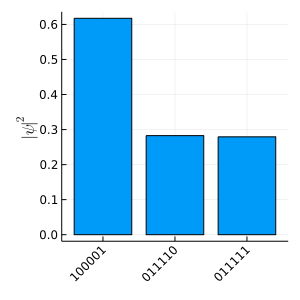

In [255]:
result = apply(prepare_init_state(ws_partitioning, ε), circ_opt_fail.moments)
result_arg_sorted = sortperm(abs2.(result))
first_arg = result_arg_sorted[length(result_arg_sorted)]
second_arg = result_arg_sorted[length(result_arg_sorted) - 1]
third_arg = result_arg_sorted[length(result_arg_sorted) - 2]
probs = [abs(result[first_arg]), abs(result[second_arg]), abs(result[third_arg])]
tags = [join(reverse(digits(first_arg-1, pad = n, base = 2))), join(reverse(digits(second_arg-1, pad = n, base = 2))), join(reverse(digits(third_arg-1, pad = n, base = 2)))]
bar(tags, probs, xticks=:all, xrotation=45, ylabel=L"|\psi|^2", legend=false, size=(300, 300))

However, using a recursive WS-QAOA with a depth of 5 does the trick:

In [162]:
p = 5
ws_rqaoa_result = recursive_ws_qaoa(graph, ws_partitioning, ε, init_state_randomized, p, rounds, lr)

Training, round 0: average objective = 6.125000000000001
Training, round 1: average objective=8.603867195582703
Training, round 2: average objective=8.151293544697351
Training, round 3: average objective=6.8947757667389125
Training, round 4: average objective=9.656198559772836
Training, round 5: average objective=10.254561020713677
Training, round 6: average objective=10.347055186304605
Training, round 7: average objective=11.618046348729116
Training, round 8: average objective=11.862453811249354
Training, round 9: average objective=11.74108165803515
Training, round 10: average objective=11.577031147072166
Training, round 11: average objective=11.747932477669032
Training, round 12: average objective=12.094694663782146
Training, round 13: average objective=12.34545138929481
Training, round 14: average objective=12.226121457530773
Training, round 15: average objective=12.422159611408775
Training, round 16: average objective=12.455758095780581
Training, round 17: average objective=12.4759

Training, round 144: average objective=16.03412699473912
Training, round 145: average objective=16.01236633105386
Training, round 146: average objective=15.984195435220153
Training, round 147: average objective=15.943701359768307
Training, round 148: average objective=15.917828783938088
Training, round 149: average objective=15.901376424628292
Training, round 150: average objective=15.939779434924656
Training, round 151: average objective=15.99351981639007
Training, round 152: average objective=16.036105501067336
Training, round 153: average objective=16.04587494261431
Training, round 154: average objective=16.026812156856803
Training, round 155: average objective=15.994129793607542
Training, round 156: average objective=15.958448503845128
Training, round 157: average objective=15.942887334205857
Training, round 158: average objective=15.936295981953105
Training, round 159: average objective=15.973098009141449
Training, round 160: average objective=16.011219282792833
Training, round 16

Training, round 287: average objective=16.030993803663677
Training, round 288: average objective=15.99686976832183
Training, round 289: average objective=15.964120871256053
Training, round 290: average objective=15.928882228741621
Training, round 291: average objective=15.931084711287273
Training, round 292: average objective=15.952190668155758
Training, round 293: average objective=16.00411163825952
Training, round 294: average objective=16.03977906364556
Training, round 295: average objective=16.045045490196934
Training, round 296: average objective=16.02251386415979
Training, round 297: average objective=15.983840433220006
Training, round 298: average objective=15.952103225374744
Training, round 299: average objective=15.920855455645512
Training, round 300: average objective=15.93477936746863
Training, round 0: average objective = 12.25
Training, round 1: average objective=12.5393202407905
Training, round 2: average objective=9.276045840979073
Training, round 3: average objective=12

Training, round 22: average objective=16.05059950646295
Training, round 23: average objective=16.14394939293498
Training, round 24: average objective=16.093372648301397
Training, round 25: average objective=16.00307862356565
Training, round 26: average objective=16.066336765310275
Training, round 27: average objective=16.14973533537578
Training, round 28: average objective=16.142584465357093
Training, round 29: average objective=16.15207301600597
Training, round 30: average objective=16.16928732110476
Training, round 31: average objective=16.143362901607247
Training, round 32: average objective=16.166227641377702
Training, round 33: average objective=16.21301639088681
Training, round 34: average objective=16.205586946975473
Training, round 35: average objective=16.193258844079065
Training, round 36: average objective=16.196337960070114
Training, round 37: average objective=16.199583498761044
Training, round 38: average objective=16.24204480103042
Training, round 39: average objective=1

Training, round 78: average objective=3.989986645259857
Training, round 79: average objective=3.9899809353751934
Training, round 80: average objective=3.989942370331602
Training, round 81: average objective=3.9900721817336073
Training, round 82: average objective=3.9902436297491497
Training, round 83: average objective=3.990323294407909
Training, round 84: average objective=3.990194726455844
Training, round 85: average objective=3.99006208863425
Training, round 86: average objective=3.990129617190105
Training, round 87: average objective=3.990224792684192
Training, round 88: average objective=3.990211088235043
Training, round 89: average objective=3.990222953549602
Training, round 90: average objective=3.9903582218467974
Training, round 91: average objective=3.9904156377889546
Training, round 92: average objective=3.9903754718002795
Training, round 93: average objective=3.990361152525446
Training, round 94: average objective=3.9904236518785092
No significant improvement, early stopping

(0, ([1, 6], [3, 2, 4, 5]))

 # Goemans-Williamson (Best known classical randomized solver) vs R-WS-QAOA
 
 We are now going to try to improve the solution of the GW-Algorithm in a fully connected graph of 8 nodes. It is important to note that this example is as minimal as it gets. For graph size below 8, GW-Algorithm almost always finds the optimal solution. It also usually produces the correct cut for the example below, but for demonstration purposes we've chosen a run, where it could not, and tried to improve it with R-WS-QAOA.
 
 If your machine is powerful enough, you could also try this with much bigger graphs, where the result would be more meaningful. For the reference, this example was run on a Intel Core i7-7700 HQ machine with Nvidia GTX 1070 graphics card.

In [151]:
edges = [
    (1, 2, 3.0), (1, 3, 5.0), (1, 4, 3.0), (1, 5, 7.0), (1, 6, 8.0), (1, 7, 1.0), (1, 8, 3.0),
    (2, 3, 14.0), (2, 4, 8.0), (2, 5, 6.0), (2, 6, 4.0), (2, 7, 3.0), (2, 8, 1.0),
    (3, 4, 11.0), (3, 5, 12.0), (3, 6, 5.0), (3, 7, 5.0), (3, 8, 9.0),
    (4, 5, 6.0), (4, 6, 16.0), (4, 7, 8.0), (4, 8, 3.0),
    (5, 6, 7.0), (5, 7, 8.0), (5, 8, 3.0),
    (6, 7, 8.0), (6, 8, 1.0),
    (7, 8, 10.0)
] # max cut size 123: 2,5,6,8 / 1,3,4,7, fully connected graph of 8 nodes
n = 8
graph = EdgeWeightedGraph(n, edges)
ws_partitioning = [0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0] # cut size 104, got with GW
ε = 0.25
init_state_randomized = true
p = 5
rounds = 300
lr = 0.1
ws = prepare_init_state(ws_partitioning, ε)
max_cut, max_partition = maxcut(adjacency_matrix(graph), iter=1)

Max iterations reached.


(104, ([2, 3, 5, 6, 8], [1, 4, 7]))

In [152]:
p = 5
rounds = 200
lr = 0.01
init_stddev = 0.00000000000000000001
recursive_ws_qaoa(graph, ws_partitioning, ε, init_state_randomized, p, rounds, lr, init_stddev)

Training, round 0: average objective = 91.25
Training, round 1: average objective=91.24999999999967
Training, round 2: average objective=91.24999999999972
Training, round 3: average objective=92.88868832370554
Training, round 4: average objective=95.32450168596631
Training, round 5: average objective=97.42503433102522
Training, round 6: average objective=99.69418112420507
Training, round 7: average objective=102.3365691696603
Training, round 8: average objective=104.1272082170422
Training, round 9: average objective=104.73759650241692
Training, round 10: average objective=105.26964887726822
Training, round 11: average objective=105.0811190455423
Training, round 12: average objective=104.63385536268768
Training, round 13: average objective=104.6380753106977
Training, round 14: average objective=105.22365750928064
Training, round 15: average objective=106.27957025986805
Training, round 16: average objective=107.40009476481602
Training, round 17: average objective=108.01343702670448
Train

Training, round 145: average objective=115.13796866159818
Training, round 146: average objective=115.14039741027946
Training, round 147: average objective=115.14277122070192
Training, round 148: average objective=115.14507360625609
Training, round 149: average objective=115.14728610639621
Training, round 150: average objective=115.14939936882182
Training, round 151: average objective=115.15140344377755
Training, round 152: average objective=115.15328611458784
Training, round 153: average objective=115.15504167442512
Training, round 154: average objective=115.15667152288873
Training, round 155: average objective=115.15817462577536
Training, round 156: average objective=115.15954957899496
Training, round 157: average objective=115.1608003918297
Training, round 158: average objective=115.16193427788848
Training, round 159: average objective=115.16295699643888
Training, round 160: average objective=115.16387563388975
Training, round 161: average objective=115.16470136520071
Training, round

Training, round 100: average objective=67.08456244814413
Training, round 101: average objective=67.0986490198018
Training, round 102: average objective=67.11160298866521
Training, round 103: average objective=67.12375122173162
Training, round 104: average objective=67.13522168480563
Training, round 105: average objective=67.14575930047728
Training, round 106: average objective=67.15535673025782
Training, round 107: average objective=67.16455464836696
Training, round 108: average objective=67.17393900185989
Training, round 109: average objective=67.18366506337637
Training, round 110: average objective=67.19357920548005
Training, round 111: average objective=67.2034671382463
Training, round 112: average objective=67.21296809567193
Training, round 113: average objective=67.22154492319152
Training, round 114: average objective=67.22888639617568
Training, round 115: average objective=67.23525929499634
Training, round 116: average objective=67.24124340967826
Training, round 117: average obje

Training, round 81: average objective=83.48873648125787
Training, round 82: average objective=83.48973680687953
Training, round 83: average objective=83.49109959388774
Training, round 84: average objective=83.49250847691819
Training, round 85: average objective=83.49316805073431
Training, round 86: average objective=83.49273169075451
Training, round 87: average objective=83.49179887656095
Training, round 88: average objective=83.49144134684919
Training, round 89: average objective=83.4922873958192
Training, round 90: average objective=83.49405393197418
Training, round 91: average objective=83.49589269191452
Training, round 92: average objective=83.4971411574301
Training, round 93: average objective=83.49775981977974
Training, round 94: average objective=83.49812670325625
Training, round 95: average objective=83.49852530636507
Training, round 96: average objective=83.49890851454137
Training, round 97: average objective=83.4991085997319
Training, round 98: average objective=83.4991389889

Training, round 103: average objective=33.382559259866454
Training, round 104: average objective=33.382557649733386
Training, round 105: average objective=33.38247847161476
Training, round 106: average objective=33.3823573216182
Training, round 107: average objective=33.382380821934184
Training, round 108: average objective=33.38254957307541
Training, round 109: average objective=33.382711601925266
Training, round 110: average objective=33.38283684357374
Training, round 111: average objective=33.38287957625807
Training, round 112: average objective=33.38283774475403
Training, round 113: average objective=33.382825857699856
Training, round 114: average objective=33.38285236481932
No significant improvement, early stopping...
Training, round 0: average objective = -1.7499999999999991
Training, round 1: average objective=-1.7499999999999956
Training, round 2: average objective=-1.7499999999999958
Training, round 3: average objective=-1.5974942218894517
Training, round 4: average objective

Training, round 139: average objective=7.9925776308669025
Training, round 140: average objective=7.9932675112211875
Training, round 141: average objective=7.994019874093635
Training, round 142: average objective=7.995065313163401
Training, round 143: average objective=7.996128708083001
Training, round 144: average objective=7.996890518016288
Training, round 145: average objective=7.997426629299669
Training, round 146: average objective=7.997913960891632
Training, round 147: average objective=7.998383838475966
Training, round 148: average objective=7.998901674004009
Training, round 149: average objective=7.999545608343701
Training, round 150: average objective=8.000181130892898
Training, round 151: average objective=8.000615674032293
Training, round 152: average objective=8.0008847268598
Training, round 153: average objective=8.00113752886914
Training, round 154: average objective=8.001411408151117
Training, round 155: average objective=8.001682178457912
Training, round 156: average obj

Training, round 125: average objective=10.751737860863447
Training, round 126: average objective=10.754159169868867
Training, round 127: average objective=10.756817405697166
Training, round 128: average objective=10.760492545625388
Training, round 129: average objective=10.765143700703
Training, round 130: average objective=10.77007158089863
Training, round 131: average objective=10.774496412056838
Training, round 132: average objective=10.778084850131123
Training, round 133: average objective=10.781085628234003
Training, round 134: average objective=10.78405899873178
Training, round 135: average objective=10.787453394881885
Training, round 136: average objective=10.791333318502524
Training, round 137: average objective=10.795406764701621
Training, round 138: average objective=10.799279165823696
Training, round 139: average objective=10.802728892454219
Training, round 140: average objective=10.805822167319972
Training, round 141: average objective=10.808818461075926
Training, round 142

(0.0, ([1, 3, 4, 7], [6, 2, 5, 8]))